<a href="https://colab.research.google.com/github/minaremeli/EquivalentPerturbations/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -c "import torch; print(torch.__version__)"


1.10.0+cu111


In [2]:
!python -c "import torch; print(torch.version.cuda)"

11.1


In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.2 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 407 kB 5.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=2765eb5200327d70a2f27fa25ace751d989a821aa1d91ac5dfbebc78a3370ca2
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import numpy as np
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data

In [5]:
# Fill in initialisation and forward method the GCNLayer below
class GCNLayer(nn.Module):
    """GCN layer to be implemented by students of practical

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=False)

    def forward(self, x, A):
        n = A.shape[0]
        A_t = A + torch.eye(n)
        D_norm = self._get_norm_degree(A_t)
        adj_norm = D_norm @ A_t @ D_norm
        x = adj_norm @ x @ self.linear.weight.T
        return x

    def _get_norm_degree(self, mtx):
      n = mtx.shape[0]
      D = (mtx @ self._ones_mtx(n)).rsqrt() * torch.eye(n)
      return D

    def _ones_mtx(self, n):
      return torch.ones((n, n))

# Lets see the GCNLayer in action!
class SimpleLinearizedGNN(nn.Module):
    """Simple GNN model using the GCNLayer implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim):
        super(SimpleLinearizedGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.gcn_layer = GCNLayer(input_dim, output_dim)
        self.activation = nn.ReLU()
        self.gcn_layer_2 = GCNLayer(output_dim, output_dim)

    def forward(self, x, A):
        x = self.gcn_layer(x, A)
        x = self.gcn_layer_2(x, A)
        y_hat = F.log_softmax(x, dim=1)
        return y_hat


gnn = SimpleLinearizedGNN(input_dim=2, output_dim=2)

### Original graph

X features:  tensor([[ 0.9278,  1.6781],
        [ 0.9281,  1.4942],
        [-2.0109, -1.1108],
        [-0.5252, -0.4087]])


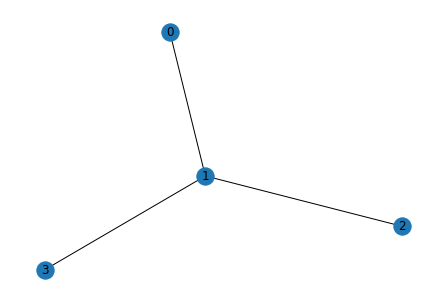

In [6]:
# x = torch.tensor([[23.4, 2], [12.5, 5], [2.6, 12], [9.1, 54]], dtype=torch.float)
x = torch.randn((4,2), dtype=torch.float)
edge_index = torch.tensor([[0, 1, 1, 3, 2, 1], 
                          [1, 0, 3, 1, 1, 2]], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

g_orig = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g_orig, with_labels=True)
print("X features: ", x)

In [7]:
def _to_dense_adj(edge_idx):
  return to_dense_adj(edge_idx)[0]

In [8]:
out = gnn(data.x, _to_dense_adj(data.edge_index))
print("Model out:\n", out)

Model out:
 tensor([[-0.8153, -0.5843],
        [-0.7787, -0.6143],
        [-0.6843, -0.7021],
        [-0.7265, -0.6609]], grad_fn=<LogSoftmaxBackward0>)


### Structure perturbation
Lets connect 0 and 3!

In [9]:
n_1, n_2 = 0, 3 # nodes that are connected in the new graph

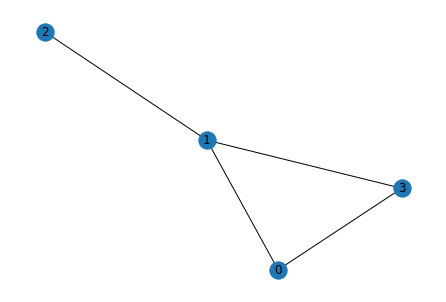

In [10]:
edge_index_new = torch.tensor([[0, 1, 1, 3, 2, 1, n_1, n_2], 
                              [1, 0, 3, 1, 1, 2, n_2, n_1]], dtype=torch.long)

data_e = Data(x=x, edge_index=edge_index_new)

g_e = torch_geometric.utils.to_networkx(data_e, to_undirected=True)
nx.draw(g_e, with_labels=True)

In [11]:
out_e = gnn(data_e.x, _to_dense_adj(data_e.edge_index))
print("Model out:\n", out_e)

Model out:
 tensor([[-0.7865, -0.6078],
        [-0.7580, -0.6322],
        [-0.6803, -0.7062],
        [-0.7865, -0.6078]], grad_fn=<LogSoftmaxBackward0>)


### Structure perturbation
Lets try to reproduce that with feature perturbations instead!

X new features:  tensor([[ 0.6247,  1.2364],
        [ 0.9281,  1.4942],
        [-2.0109, -1.1108],
        [-0.5252, -0.4087]])


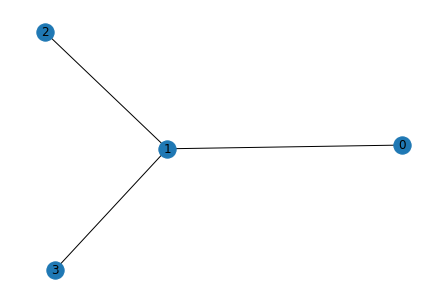

In [15]:
def d_o(node):
  return 1 + g_orig.degree(node)

def d_e(node):
  return 1 + g_e.degree(node)

def get_norm_degree_mtx(A):
  n = A.shape[0]
  return (A @ torch.ones((n, n))).rsqrt() * torch.eye(n)

x_new = torch.clone(x)
A = _to_dense_adj(data.edge_index)
A_e = _to_dense_adj(data_e.edge_index)

c_ii = (1 / (d_o(n_1)* d_o(n_1))) ** 0.5
c_jj = (1 / (d_o(n_2) * d_o(n_2)) ) ** 0.5
c_ij_e = (1 / (d_e(n_1) * d_e(n_2)) ) ** 0.5
A_t = A + torch.eye(4)
A_t_e = A_e + torch.eye(4)
Dn_o = get_norm_degree_mtx(A_t)
Dn_e = get_norm_degree_mtx(A_t_e)
C_ij_o = torch.matrix_power(Dn_o @ A_t @ Dn_o, 2)
C_ij_e = torch.matrix_power(Dn_e @ A_t_e @ Dn_e, 2)
c_ii_inv = (C_ij_o * torch.eye(4)).inverse().diagonal()
C_diff = C_ij_e - C_ij_o
diff = (C_diff @ x).T * c_ii_inv
# print(diff.T)

# x_new += diff.T
x_new[n_1] += diff.T[n_1]
# x_new[n_2] += diff.T[n_2]

# print(x_new - x)

# for _ in range(2):
#   d0 = (x_new - x)[n_1]
#   d3 = (x_new - x)[n_2]
#   d2 = (x_new - x)[2]
#   x_new[1] -= (d0 + d2 + d3) * 2/2**0.5

#   print((d0 + d3) * 2/2**0.5 + d2 * 1/2**0.5)

#   # print(x_new - x)

#   d1 = (x_new - x)[1]
#   x_new[2] -= d1 * (1/2**0.5)
#   x_new[n_1] -= d1 * (1/2**0.5)
#   x_new[n_2] -= d1 * (1/2**0.5)

#   print(d1 * (1/2**0.5))

# print(x_new - x)

data_f = Data(x=x_new, edge_index=edge_index)

g_f = torch_geometric.utils.to_networkx(data_f, to_undirected=True)
nx.draw(g_f, with_labels=True)
print("X new features: ", x_new)

In [16]:
out_f = gnn(data_f.x, _to_dense_adj(data_f.edge_index))
print("Model out:\n", out_f)

Model out:
 tensor([[-0.7865, -0.6078],
        [-0.7589, -0.6315],
        [-0.6756, -0.7110],
        [-0.7175, -0.6694]], grad_fn=<LogSoftmaxBackward0>)


### Results

As we can see, the output at the targeted node (n_1) of the feature perturbed and the structure perturbed GNN is not all that different.

In [18]:
(out_e - out_f)[n_1]

tensor([-5.9605e-08,  0.0000e+00], grad_fn=<SelectBackward0>)